<a href="https://colab.research.google.com/github/juliosdutra/ModelagemPPEQ1019/blob/main/exemplo_CO2_ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [5]:
# URL direta para o arquivo XLS no GitHub
url = "https://github.com/juliosdutra/ModelagemPPEQ1019/raw/refs/heads/main/dados_CO2_emissao.xls"

# Lê o arquivo XLS usando pandas
dados = pd.read_excel(url)

# Exibe as primeiras linhas da planilha
dados.head()

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,11092.675,11576.719,12713.489,12178.107,11840.743,10623.299,9933.903,12236.779,11378.701,...,2823.590,2658.575,2629.239,2508.228,2500.894,1349.456,861.745,872.746,898.415,883.747
1,Afghanistan,414.371,491.378,689.396,707.731,839.743,1008.425,1092.766,1283.450,1224.778,...,2273.540,4206.049,6769.282,8463.436,12240.446,10755.311,9050.156,8467.103,9035.488,8672.455
2,Angola,550.050,454.708,1180.774,1151.438,1224.778,1188.108,1554.808,993.757,1672.152,...,25151.953,25709.337,27792.193,29057.308,30586.447,34176.440,33692.396,44851.077,34583.477,34693.487
3,Albania,2024.184,2280.874,2464.224,2082.856,2016.850,2174.531,2552.232,2680.577,3072.946,...,3927.357,4374.731,4378.398,4598.418,5240.143,4924.781,4913.780,5489.499,4616.753,4536.079
4,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,539.049,539.049,517.047,517.047,491.378,487.711,476.710,462.042,465.709,469.376


ADF Statistic: 0.8629338813032948
p-value: 0.9925870271721168
 
ADF Statistic: -3.6922387265087213
p-value: 0.004223657338216783


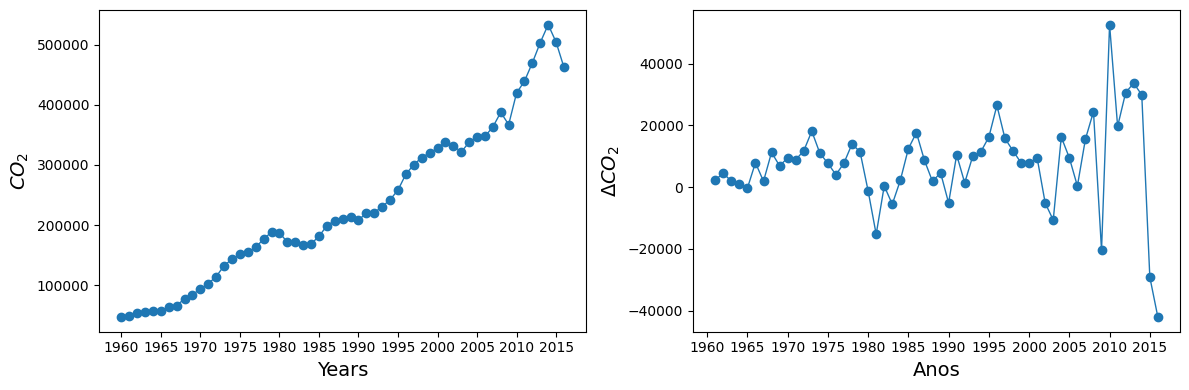

In [17]:
# Dados apenas do Brasil
i = dados['Country Name'] == 'Brazil'

CO2_BR = dados[i].iloc[0,1:]

dados_BR = pd.DataFrame(columns=['CO2'])
dados_BR['CO2'] = CO2_BR.values
dados_BR['CO2'] = dados_BR.CO2.astype(float)
dados_BR.index = range(1960,2017)

figure, axes = plt.subplots(1, 2, figsize=(12,4))
eixo_x = np.arange(1960,2016,5)
dados_BR['CO2'].plot(marker='o', lw = 1, xticks=eixo_x, ax=axes[0])
axes[0].set_xlabel("Years", fontsize=14)
axes[0].set_ylabel('$CO_2$', fontsize=14)


# Teste de estacionaridade
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(CO2_BR.values)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# diferenciando os dados
dados_BR['CO2'].diff().plot(marker='o', lw = 1, xticks=eixo_x, ax=axes[1])
axes[1].set_xlabel("Anos", fontsize=14)
axes[1].set_ylabel('$\Delta CO_2$', fontsize=14)
plt.tight_layout()

print(' ')

diff_CO2 = dados_BR['CO2'].diff().iloc[1:]
ad_fuller_result = adfuller(diff_CO2)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [18]:
#%%  Dividindo os dados para backtesting: walk-forward method
n = len(dados_BR['CO2'])
i_treino = n-10 # corte de indice para treino (arbitrário)

Xtreino = dados_BR['CO2'].iloc[0:i_treino] # dados de 1960 a 2006
Xteste = dados_BR['CO2'].iloc[i_treino:] # dados de 2007 a 2016

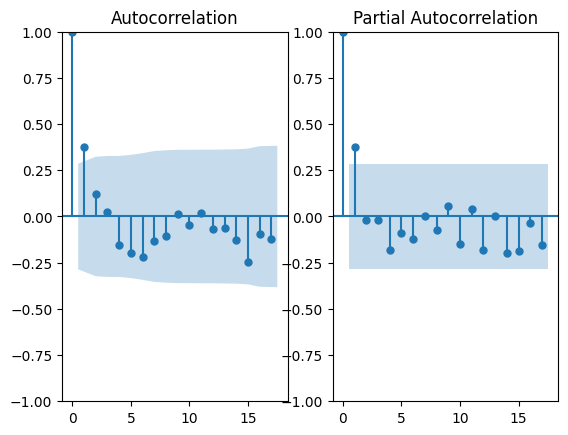

<Figure size 640x480 with 0 Axes>

In [19]:
#%% Análise
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

N_lags = 20

plt.figure(2)
an1 = plt.subplot(1,2,1)
plot_acf(diff_CO2.iloc[0:i_treino], ax=an1)

an2 = plt.subplot(1,2,2)
plot_pacf(diff_CO2.iloc[:i_treino], ax=an2)

plt.show()
plt.tight_layout()

In [ ]:
#%% Buscador de modelos ARIMA

from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook

def optimize_ARIMA(order_list, endog):
    """
        Return dataframe with parameters and corresponding AIC

        order_list - list with (p, d, q) tuples
        endog - the endogenous variable
    """

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=order).fit(disp=-1)
        except:
            continue

        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [20]:
#%% Buscando nesses intervalos
ps = range(0, 5)
d = 1
qs = range(0, 5)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)

result_df = optimize_ARIMA(order_list, endog=Xtreino)

print(result_df)

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    (p, d, q)         AIC
0   (2, 1, 1)  960.796334
1   (1, 1, 2)  961.161233
2   (3, 1, 1)  962.806645
3   (2, 1, 2)  962.916906
4   (1, 1, 3)  963.503960
5   (4, 1, 1)  964.678963
6   (3, 1, 2)  964.880482
7   (2, 1, 3)  965.301351
8   (1, 1, 4)  965.956978
9   (1, 1, 1)  966.094741
10  (1, 1, 0)  966.301212
11  (4, 1, 2)  966.864900
12  (2, 1, 0)  966.965876
13  (2, 1, 4)  967.918940
14  (4, 1, 3)  968.210553
15  (3, 1, 3)  968.214503
16  (3, 1, 0)  968.522344
17  (3, 1, 4)  968.780563
18  (0, 1, 2)  969.760033
19  (4, 1, 0)  970.086413
20  (4, 1, 4)  970.404495
21  (0, 1, 3)  970.956248
22  (0, 1, 1)  971.101897
23  (0, 1, 4)  973.361737
24  (0, 1, 0)  981.308599


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
#%% Resultado

ordem = result_df.iloc[0,0]

model = SARIMAX(Xtreino, order=ordem).fit(trend='nc', disp=False)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                    CO2   No. Observations:                   47
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -476.398
Date:                Wed, 22 Jan 2025   AIC                            960.796
Time:                        19:12:18   BIC                            968.111
Sample:                             0   HQIC                           963.536
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2410      0.098     12.663      0.000       1.049       1.433
ar.L2         -0.2410      0.098     -2.458      0.014      -0.433      -0.049
ma.L1         -0.9981      0.227     -4.405      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


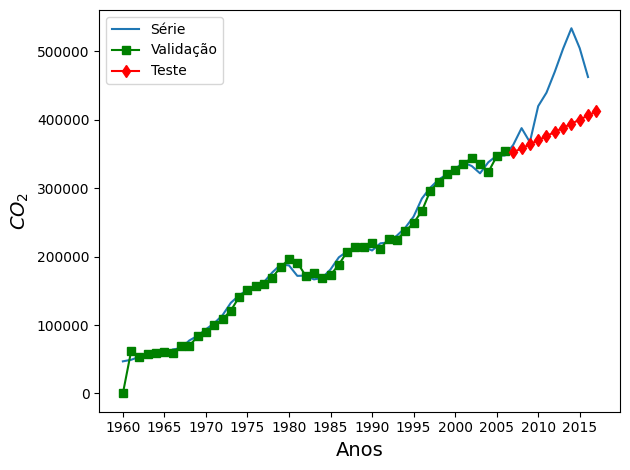

In [25]:
#%% método holdout

predictions = model.predict(start=0, end=n)

plt.figure(3)
eixo_x = np.arange(1960,2016,5)
dados_BR['CO2'].plot(xticks=eixo_x)
predictions.iloc[0:i_treino].plot(marker='s',color='g')
predictions.iloc[i_treino:].plot(marker='d',color='r')
plt.xlabel("Anos", fontsize=14)
plt.ylabel('$CO_2$', fontsize=14)
plt.legend(['Série','Validação','Teste'])
plt.tight_layout()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


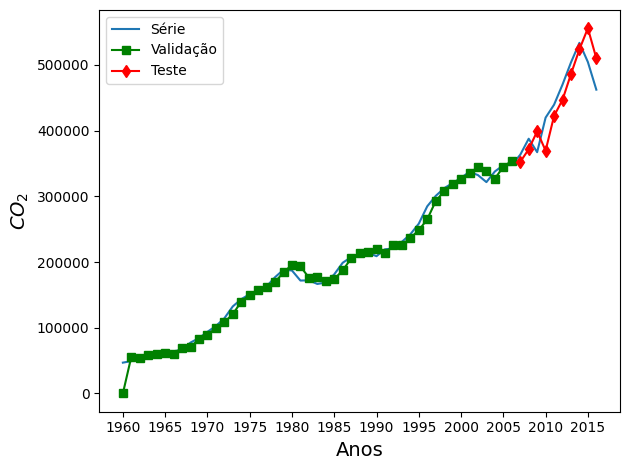

In [26]:
#%% método walk-forward

# Na prática, muito provavelmente iremos treinar novamente nosso modelo
# à medida que novos dados se tornem disponíveis.
# As novas medidas aqui são os dados de teste.

n_teste = len(Xteste)
Xforecast = np.zeros(n_teste)

for k in range(0,n_teste):

    # dados de treino + 1 dado "novo"
    X = dados_BR['CO2'].iloc[0:i_treino+k+1]

    # ajuste com apenas o dados de treino
    model = SARIMAX(X[0:-1], order=ordem).fit(trend='nc', disp=False)

    # predição para dados de treino + 1 dado "novo"
    predictions = model.predict(start=0, end=i_treino+k)

    Xforecast[k] = predictions.iloc[-1]


plt.figure(4)
dados_BR['CO2'].plot(xticks=eixo_x)
predictions.iloc[0:i_treino].plot(marker='s',color='g')
plt.plot(predictions.index[i_treino:], Xforecast, '-dr')
plt.xlabel("Anos", fontsize=14)
plt.ylabel('$CO_2$', fontsize=14)
plt.legend(['Série','Validação','Teste'])
plt.tight_layout()